In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

# Mutual correlation

In [2]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


Files already downloaded and verified
cuda


In [11]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
round_set = [x for x in round_set if x >= 30]
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30] 4
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [5]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")
print(formatted_date_time)

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

for idround, round_number in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{round_number}_normal'][0:normal_nums] + modelpth_dict[f'{round_number}_attack'][0:attack_nums]
    global_model_pth = [gm for gm in gmodelpth_set if (int(re.findall(r'-?\d+', gm)[-1]) == round_number)][0]
    print(global_model_pth)
    r_corr = np.zeros((total_nums, total_nums, 1))

    fvlist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    
    g_gradient = getGradients(modelpth=global_model_pth, model=model, dataloader=Dataloader)

    for idx, modelp1 in enumerate(r_modelpth_set):
        model.load_state_dict(torch.load(modelp1))
        gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
     
    # print(gradientlist[0])
    # 定义权重键名列表
    global_grad = [g_gradient[key] for key in weight_keys]

    # 使用列表推导式创建 local_grad 和 global_grad 列表

    for id1, v1 in enumerate(gradientlist):
        if id1 >= total_nums:
            break
        local_grad_1 = [v1[key] for key in weight_keys]
        for id2, v2 in enumerate(gradientlist):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            local_grad_2 = [v2[key] for key in weight_keys]
            corrlist = []

            for layer_id, _ in enumerate(local_grad_1):
                nd_vector = np.prod(local_grad_1[layer_id].cpu().shape)

                ly1 = local_grad_1[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])
                ly2 = local_grad_2[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])

                l = linear_CKA(ly1.T, ly2.T)
                k = kernel_CKA(ly1.T, ly2.T)

                corrlist.append((l+k)/2)
            
            r_corr[id1][id2] = np.mean(np.array(corrlist)) 
        # fvlist.append(np.array(corrlist))
        # print(fvlist[-1])


    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)
    

2024-01-13 17:39:39
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_36.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_34.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_32.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_30.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/patte

In [6]:
np.savetxt(f"./data/corrset_temp_v4_5_{formatted_date_time}.txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))
print(formatted_date_time)

2024-01-13 17:39:39


# PCODE

In [7]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping

36 (36, 36)


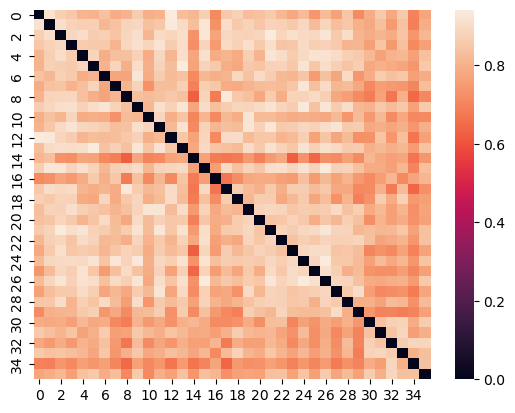

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


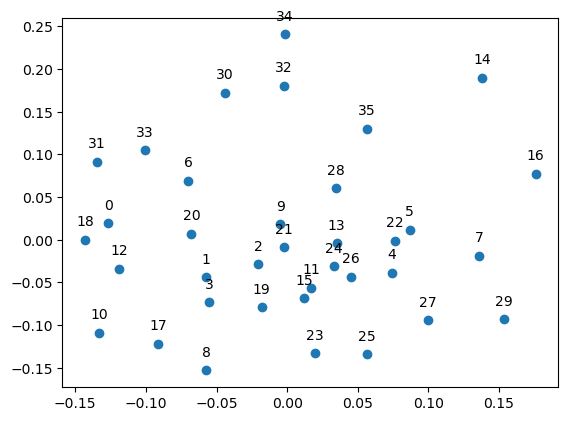

d 0 0 0.0 inf []
d 0 1 0.0 0.16861555444903564 [[1, 14]]
d 0 2 0.0 0.14016336463711476 [[5, 16]]
d 0 3 0.0 0.1279430439475172 [[30, 32]]
d 0 4 0.0 0.12221683249899085 [[18, 33]]
d 0 5 0.0 0.11762021510618936 [[30, 33]]
d 0 6 0.0 0.11111940613464377 [[31, 33]]
d 0 7 0.0 0.1105536659899733 [[32, 34]]
d 0 8 0.0 0.11017156812463524 [[32, 35]]
d 0 9 0.0 0.1005084548462516 [[6, 20]]
d 0 10 0.0 0.09840195054135215 [[27, 29]]
d 0 11 0.0 0.09578143520941773 [[12, 18]]
d 0 12 0.0 0.09394952552200098 [[1, 17]]
d 0 13 0.0 0.0934935009362734 [[9, 28]]
d 0 14 0.0 0.08609152656835162 [[2, 23]]
d 0 15 0.0 0.08521944863106323 [[15, 22]]
d 0 16 0.0 0.08335056512858363 [[4, 25]]
d 0 17 0.0 0.07836279161512771 [[3, 11]]
d 0 18 0.0 0.07679924138403993 [[4, 21]]
d 0 19 0.0 0.07654735326954332 [[10, 19]]
d 0 20 0.0 0.07590279819636425 [[11, 19]]
d 0 21 0.0 0.07582335605790436 [[6, 9]]
d 0 22 0.0 0.07529531892962693 [[9, 13]]
d 0 23 0.0 0.07489337421920872 [[11, 27]]
d 0 24 0.0 0.07132936675053891 [[2, 15]]
d

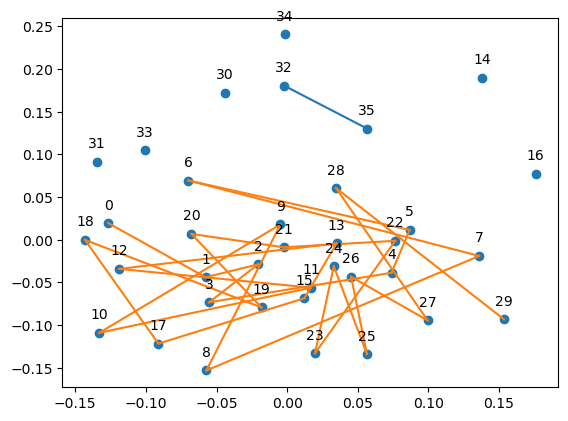

persistence =0.11111940613464377, finding: [32, 34]
 [[32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
merging
[[34]]
[[0, 0]]
pbow:
[array([0., 2., 0.]), array([ 8.,  5., 14.])]
[[ 0.         16.40121947]
 [16.40121947  0.        ]]
score x0.5166666666666667: [1.0] [0.0] 
total score : 1.0

[[32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]


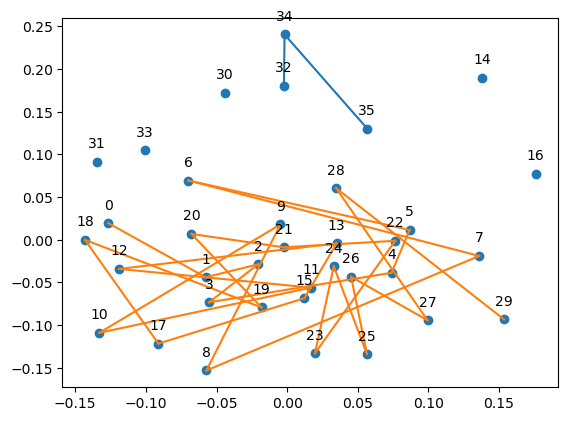

persistence =0.11762021510618936, finding: [31, 33]
 [[31, 33], [32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
merging
[]
[]
pbow:
[array([1., 0.]), array([2., 0.]), array([ 7., 20.])]
[[ 0.          1.         20.88061302]
 [ 1.          0.         20.61552813]
 [20.88061302 20.61552813  0.        ]]
score x0.55: [1.0] [1.0] [0.0] 
total score : 1.0

[[31, 33], [32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]


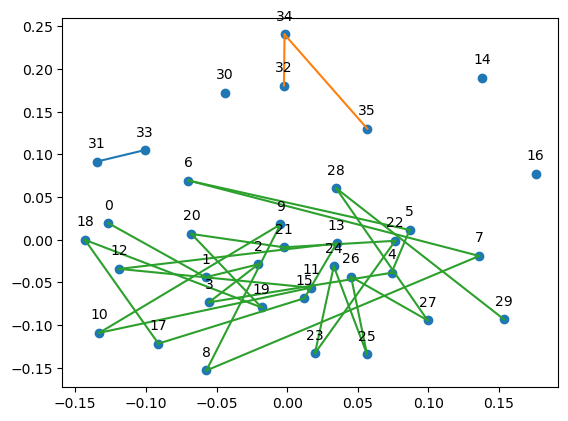

persistence =0.12221683249899085, finding: [30, 33]
 [[33, 30, 31], [32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
merging
[[30]]
[[0, 0]]
pbow:
[array([0., 2., 0.]), array([0., 2., 0.]), array([14.,  5.,  8.])]
[[ 0.          0.         16.40121947]
 [ 0.          0.         16.40121947]
 [16.40121947 16.40121947  0.        ]]
score x0.5666666666666667: [1.0] [1.0] [0.0] 
total score : 1.0

[[33, 30, 31], [32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]


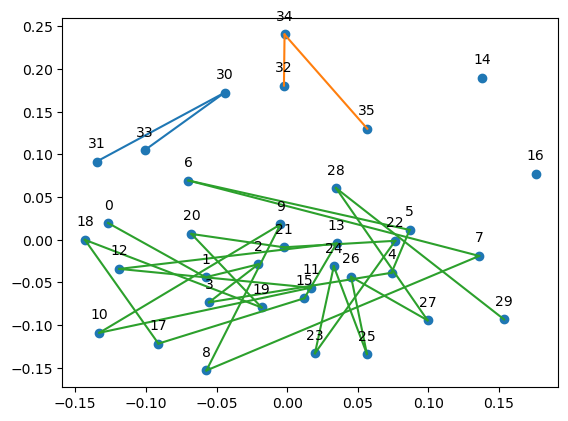

persistence =0.1279430439475172, finding: [18, 33]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33], [32, 34, 35]]
merging
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 33]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  16.401219466856727 16.401219466856727
pbow:
[array([ 8., 19.,  3.]), array([0., 0., 2.])]
[[ 0.         20.63976744]
 [20.63976744  0.        ]]
score x0.5666666666666667: [0.0967741935483871] [1.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33], [32, 34, 35]]


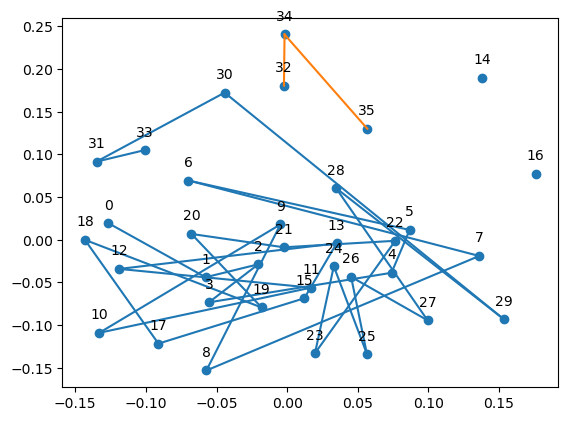

persistence =0.14016336463711476, finding: [30, 32]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[32, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  20.639767440550294 20.639767440550294
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.16861555444903564, finding: [5, 16]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[16]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



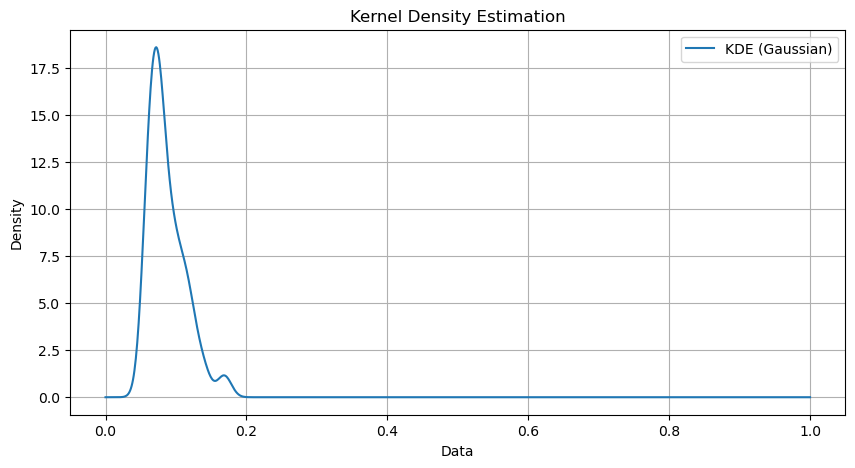

34 (36, 36)


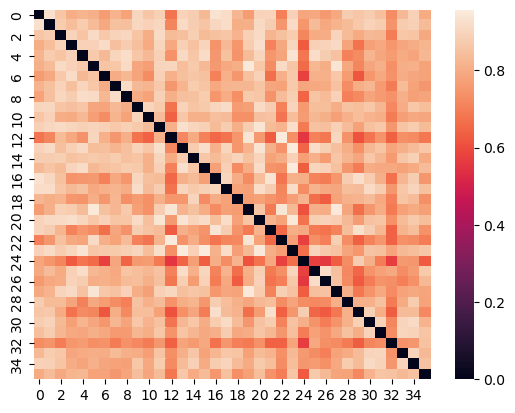

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


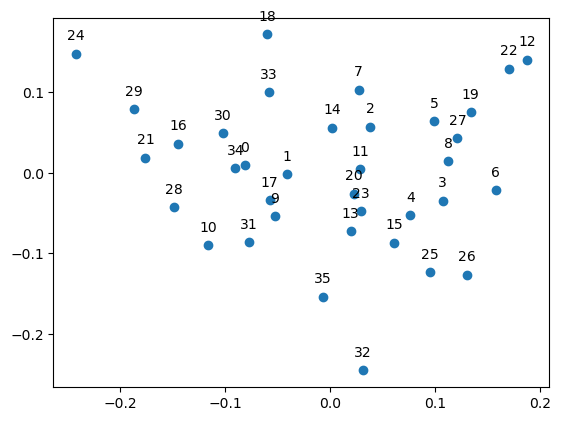

d 0 0 0.0 inf []
d 0 1 0.0 0.14673074822741639 [[32, 35]]
d 0 2 0.0 0.1286978146174821 [[25, 35]]
d 0 3 0.0 0.12072009101111603 [[24, 29]]
d 0 4 0.0 0.11855802885800393 [[0, 28]]
d 0 5 0.0 0.10247985240325397 [[14, 18]]
d 0 6 0.0 0.10145323003264084 [[33, 34]]
d 0 7 0.0 0.10074156086681263 [[9, 10]]
d 0 8 0.0 0.09856396357301378 [[31, 33]]
d 0 9 0.0 0.09835884810336559 [[11, 14]]
d 0 10 0.0 0.08568462221063933 [[17, 30]]
d 0 11 0.0 0.0848485629490604 [[30, 34]]
d 0 12 0.0 0.08470599080725127 [[2, 5]]
d 0 13 0.0 0.08450093615357113 [[2, 11]]
d 0 14 0.0 0.08266527191020667 [[7, 8]]
d 0 15 0.0 0.08255455695924929 [[3, 6]]
d 0 16 0.0 0.08046086134542152 [[9, 17]]
d 0 17 0.0 0.08015952038378449 [[4, 25]]
d 0 18 0.0 0.07959171046137403 [[4, 8]]
d 0 19 0.0 0.07925456583558399 [[25, 26]]
d 0 20 0.0 0.07715602152410106 [[17, 23]]
d 0 21 0.0 0.0767669817476545 [[0, 17]]
d 0 22 0.0 0.0741913720215297 [[3, 20]]
d 0 23 0.0 0.07092174044576405 [[21, 29]]
d 0 24 0.0 0.0692943226294559 [[0, 1]]
d 0 25

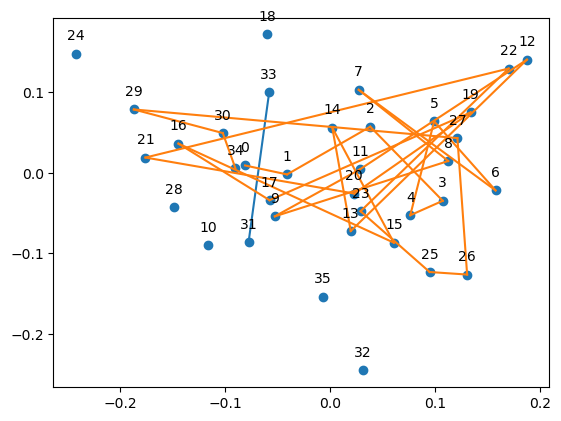

persistence =0.10145323003264084, finding: [9, 10]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 34], [31, 33]]
merging
[[10]]
[[1, 0]]
pbow:
[array([17., 11.]), array([1., 0.])]
[[ 0.         19.41648784]
 [19.41648784  0.        ]]
score x0.5166666666666667: [0.06896551724137931] [1.0] 
total score : 0.9444444444444444

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 34], [31, 33]]


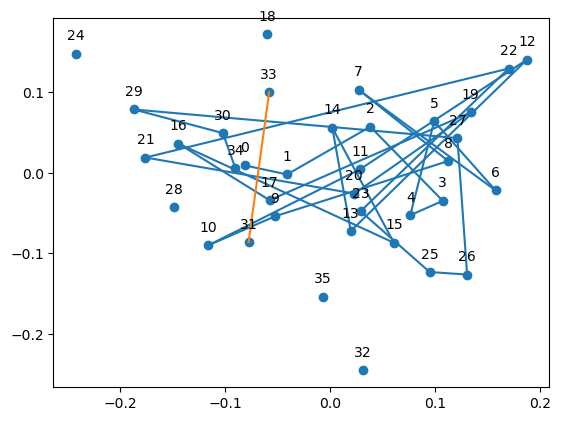

persistence =0.10247985240325397, finding: [33, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34]]
merging
[[31, 33], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 34]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  19.4164878389476 19.4164878389476
score x0.5166666666666667: [0.12903225806451613] 
total score : 0.8888888888888888

persistence =0.11855802885800393, finding: [14, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34]]
merging
[[18]]
[[0, 0]]
score x0.5333333333333333: [0.125] 
total score : 0.8888888888888888

persistence =0.12072009101111603, finding: [0, 28]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34]]
merging
[[28]]
[[0, 0]]
score x0.55: [0.12121212121212122] 
total score : 0.8888888888888888



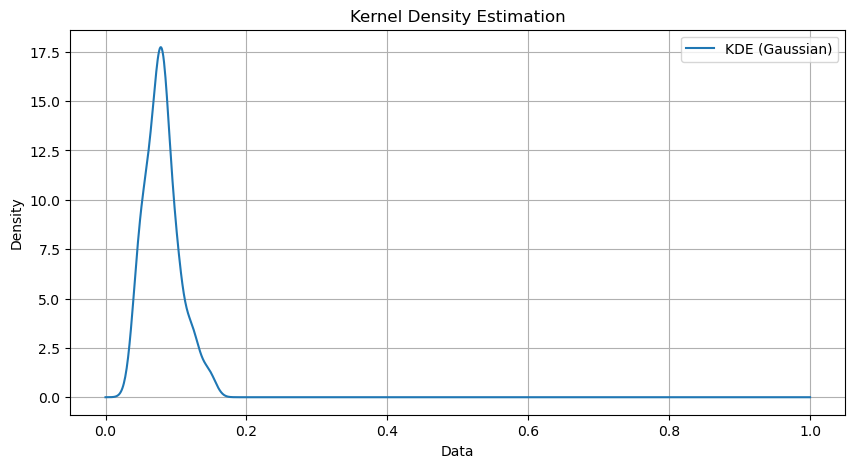

32 (36, 36)


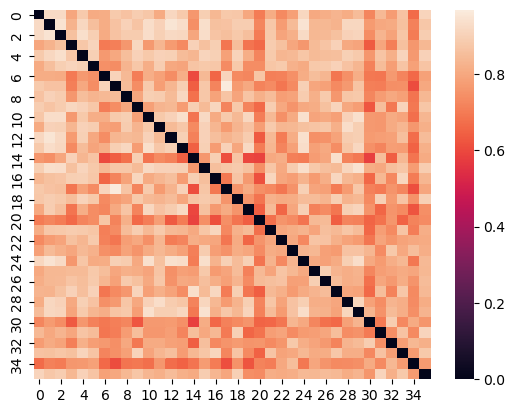

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


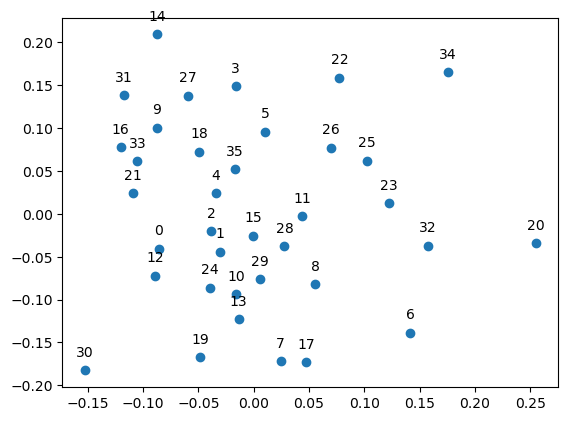

d 0 0 0.0 inf []
d 0 1 0.0 0.14574933956084524 [[23, 34]]
d 0 2 0.0 0.1277609317389039 [[6, 20]]
d 0 3 0.0 0.11901850973949057 [[23, 32]]
d 0 4 0.0 0.11606324235670096 [[5, 26]]
d 0 5 0.0 0.115174761156555 [[5, 22]]
d 0 6 0.0 0.1123240785239783 [[15, 23]]
d 0 7 0.0 0.11088785488757302 [[30, 32]]
d 0 8 0.0 0.10436796999443543 [[25, 26]]
d 0 9 0.0 0.09657223624040545 [[13, 17]]
d 0 10 0.0 0.09293548763485793 [[4, 18]]
d 0 11 0.0 0.09090043638646039 [[4, 33]]
d 0 12 0.0 0.0904726752722248 [[3, 5]]
d 0 13 0.0 0.09029975102199694 [[6, 17]]
d 0 14 0.0 0.09008428554174364 [[31, 35]]
d 0 15 0.0 0.08853205633690653 [[0, 35]]
d 0 16 0.0 0.08563585994187983 [[16, 33]]
d 0 17 0.0 0.08518392621568627 [[16, 21]]
d 0 18 0.0 0.08499343851008423 [[9, 16]]
d 0 19 0.0 0.08327048731771736 [[16, 27]]
d 0 20 0.0 0.08319270154504299 [[1, 28]]
d 0 21 0.0 0.08200133878634086 [[8, 13]]
d 0 22 0.0 0.08109550204905414 [[3, 9]]
d 0 23 0.0 0.07724828998798139 [[13, 19]]
d 0 24 0.0 0.07449904933937734 [[0, 2]]
d 0 2

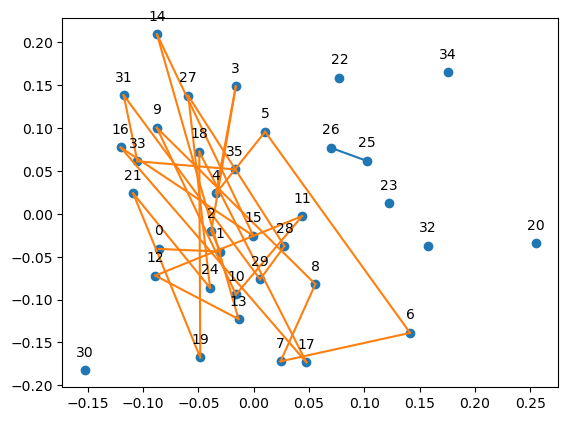

persistence =0.1123240785239783, finding: [30, 32]
 [[30, 32], [25, 26], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 31, 33, 35]]
merging
[]
[]
pbow:
[array([1., 0.]), array([1., 0.]), array([16., 11.])]
[[ 0.          0.         18.60107524]
 [ 0.          0.         18.60107524]
 [18.60107524 18.60107524  0.        ]]
score x0.5333333333333333: [1.0] [0.0] [0.10714285714285714] 
total score : 0.9166666666666666

[[30, 32], [25, 26], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 31, 33, 35]]


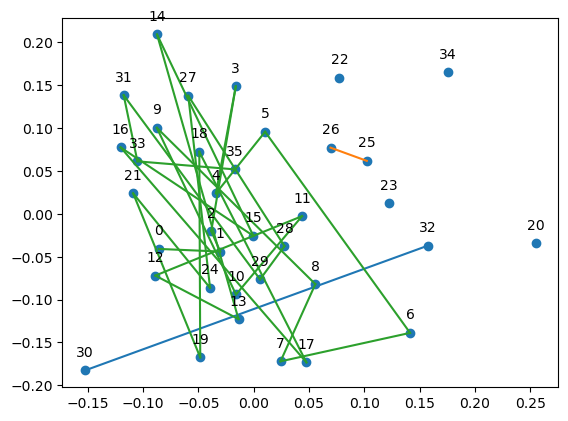

persistence =0.115174761156555, finding: [15, 23]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 27, 28, 29, 31, 33, 35], [30, 32], [25, 26]]
merging
[[23]]
[[2, 0]]
pbow:
[array([11., 17.]), array([0., 1.]), array([0., 1.])]
[[ 0.         19.41648784 19.41648784]
 [19.41648784  0.          0.        ]
 [19.41648784  0.          0.        ]]
score x0.55: [0.10344827586206896] [1.0] [0.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 27, 28, 29, 31, 33, 35], [30, 32], [25, 26]]


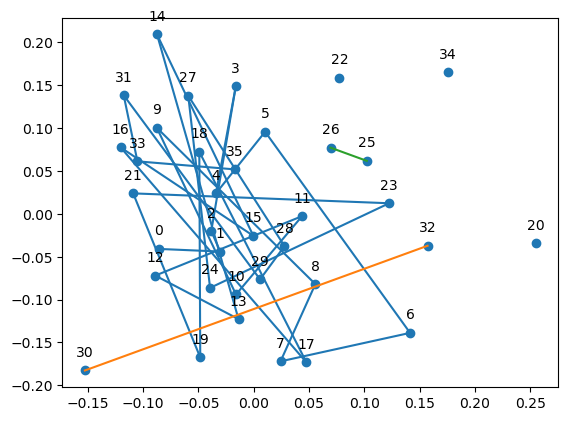

persistence =0.11606324235670096, finding: [5, 22]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 29, 31, 33, 35], [30, 32], [25, 26]]
merging
[[22]]
[[0, 0]]
pbow:
[array([17., 12.]), array([1., 0.]), array([1., 0.])]
[[ 0. 20. 20.]
 [20.  0.  0.]
 [20.  0.  0.]]
score x0.5666666666666667: [0.1] [1.0] [0.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 29, 31, 33, 35], [30, 32], [25, 26]]


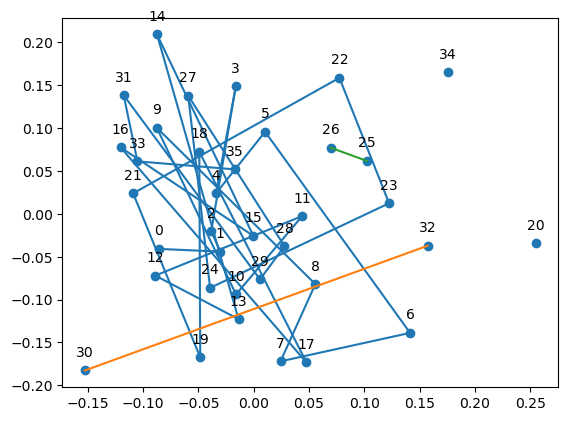

persistence =0.11901850973949057, finding: [5, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [30, 32]]
merging
[[25, 26], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 29, 31, 33, 35]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  20.0 20.0
pbow:
[array([19., 12.]), array([1., 0.])]
[[ 0.         21.63330765]
 [21.63330765  0.        ]]
score x0.5666666666666667: [0.09375] [1.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [30, 32]]


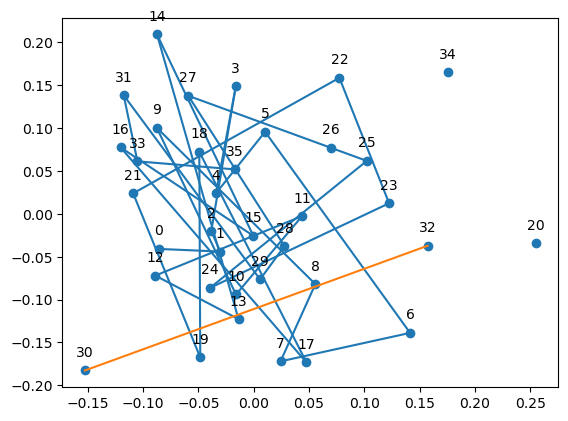

persistence =0.1277609317389039, finding: [23, 32]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[30, 32], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  21.633307652783937 21.633307652783937
score x0.5666666666666667: [0.14705882352941177] 
total score : 0.8611111111111112

persistence =0.14574933956084524, finding: [6, 20]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[20]]
[[0, 0]]
score x0.5833333333333334: [0.14285714285714285] 
total score : 0.8611111111111112



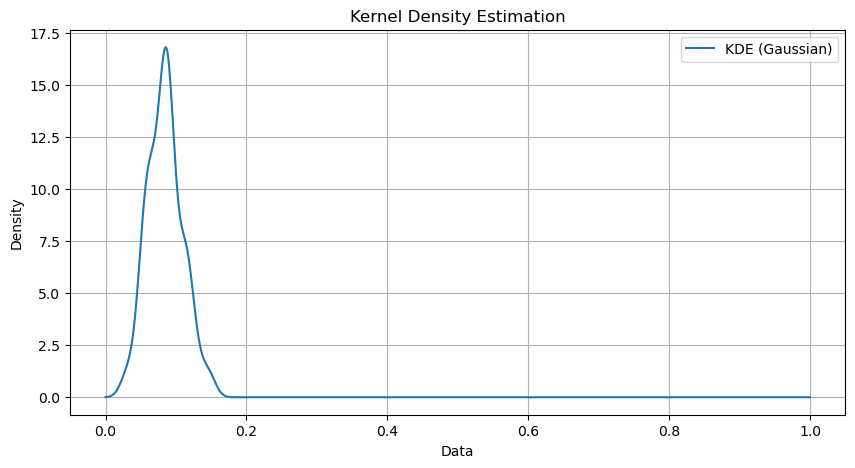

30 (36, 36)


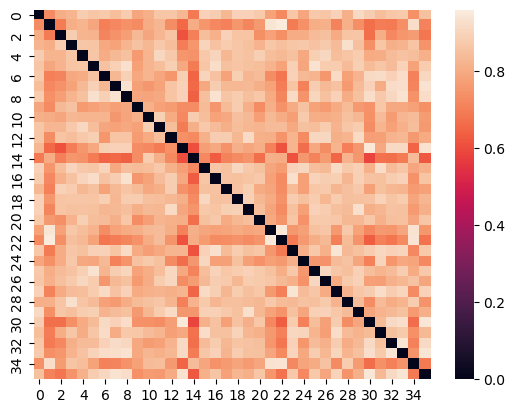

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


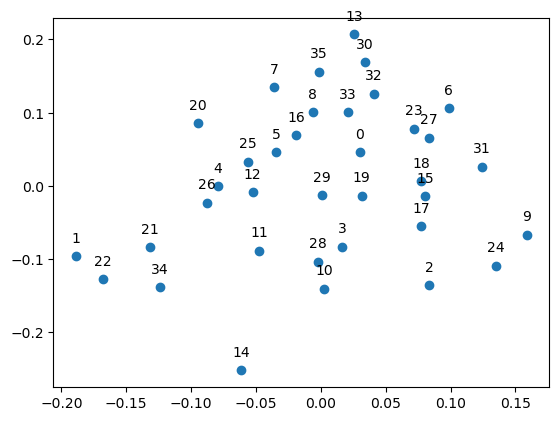

d 0 0 0.0 inf []
d 0 1 0.0 0.12252431320684587 [[10, 14]]
d 0 2 0.0 0.12076519757851267 [[9, 18]]
d 0 3 0.0 0.11920618742588152 [[28, 34]]
d 0 4 0.0 0.11491693556010996 [[4, 20]]
d 0 5 0.0 0.1130585883816837 [[10, 11]]
d 0 6 0.0 0.11285521892306771 [[17, 19]]
d 0 7 0.0 0.10663966440610295 [[2, 17]]
d 0 8 0.0 0.09875939764665798 [[3, 15]]
d 0 9 0.0 0.0914395322378253 [[15, 24]]
d 0 10 0.0 0.0913525204942709 [[4, 26]]
d 0 11 0.0 0.09105923003040128 [[25, 26]]
d 0 12 0.0 0.08917620260857306 [[15, 18]]
d 0 13 0.0 0.08905039715757601 [[4, 11]]
d 0 14 0.0 0.08904064616546137 [[12, 25]]
d 0 15 0.0 0.08692012922157866 [[0, 29]]
d 0 16 0.0 0.08375603831267275 [[12, 29]]
d 0 17 0.0 0.0756453716990827 [[6, 33]]
d 0 18 0.0 0.07500843143368296 [[15, 31]]
d 0 19 0.0 0.07415333615691055 [[27, 31]]
d 0 20 0.0 0.0688161422618524 [[5, 8]]
d 0 21 0.0 0.06878081841577455 [[16, 23]]
d 0 22 0.0 0.06874295077866788 [[3, 28]]
d 0 23 0.0 0.06868331221896895 [[19, 29]]
d 0 24 0.0 0.06487885329997722 [[7, 8]]
d 

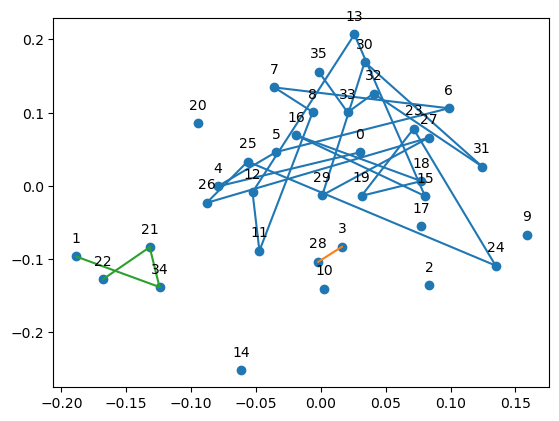

persistence =0.10663966440610295, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 9., 11.,  0.,  5.]), array([0., 0., 1., 2.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


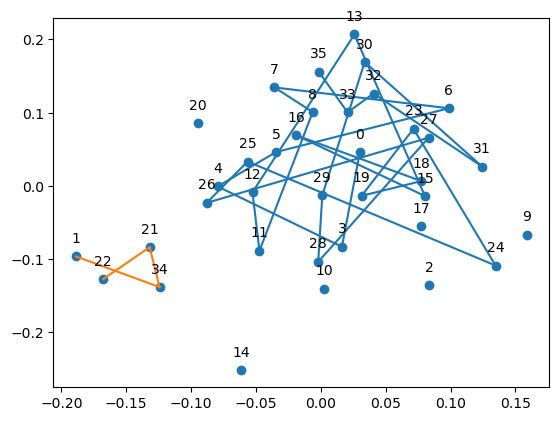

persistence =0.11285521892306771, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([1., 0.]), array([ 9., 16.]), array([0., 3.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


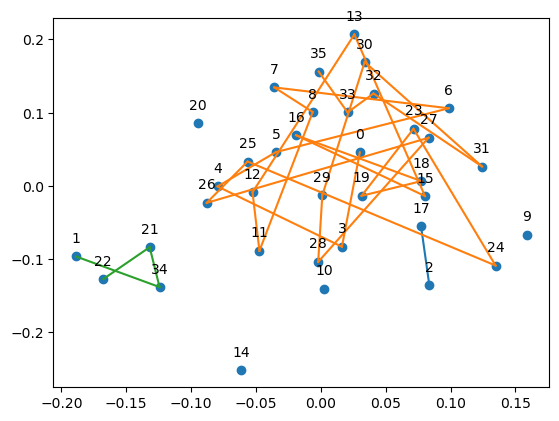

persistence =0.1130585883816837, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 8., 11.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


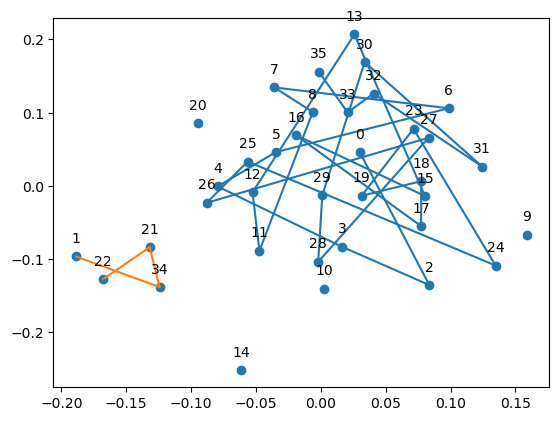

persistence =0.11491693556010996, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 3., 11.,  5.,  9.]), array([0., 0., 3., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


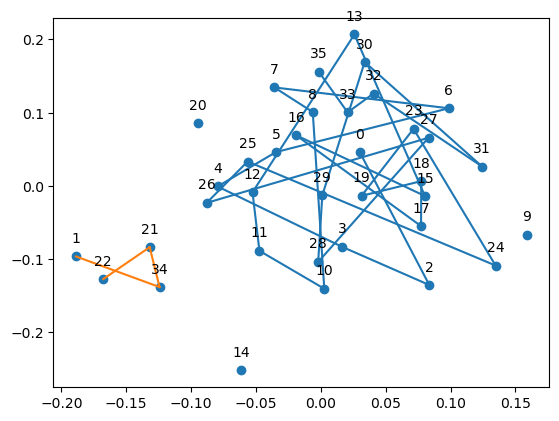

persistence =0.11920618742588152, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 9., 11.,  4.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


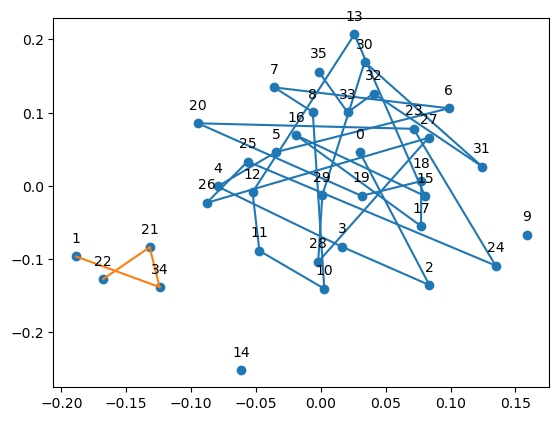

persistence =0.12076519757851267, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252431320684587, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



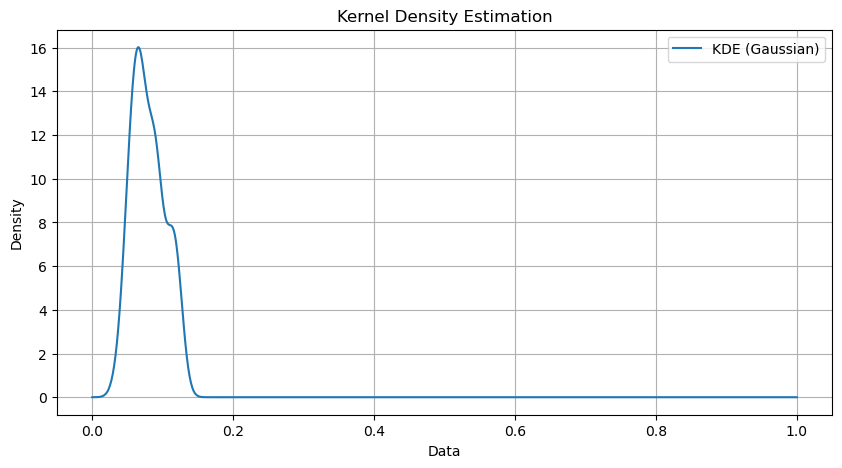

28 (36, 36)


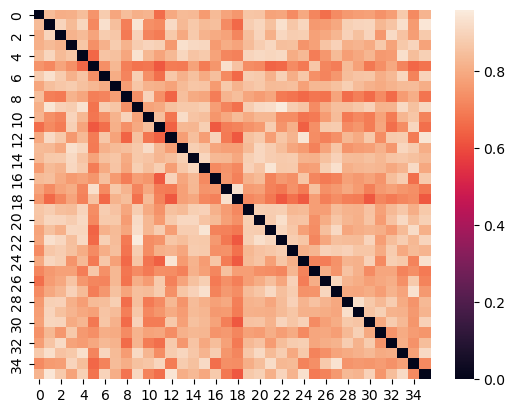

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


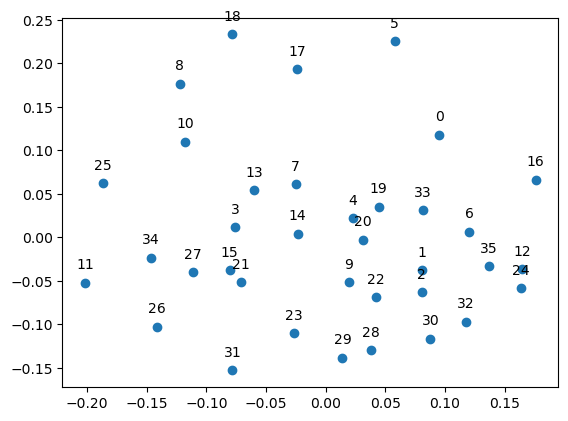

d 0 0 0.0 inf []
d 0 1 0.0 0.1336462571500514 [[5, 25]]
d 0 2 0.0 0.1297202655680899 [[7, 17]]
d 0 3 0.0 0.12062947269705138 [[0, 6]]
d 0 4 0.0 0.11466409696216495 [[7, 28]]
d 0 5 0.0 0.10920565634791612 [[29, 31]]
d 0 6 0.0 0.10455799534577592 [[23, 28]]
d 0 7 0.0 0.10366663674852572 [[12, 16]]
d 0 8 0.0 0.1012396958109425 [[8, 10]]
d 0 9 0.0 0.09850631270521337 [[1, 29]]
d 0 10 0.0 0.09743149027908327 [[4, 19]]
d 0 11 0.0 0.09649084452536028 [[26, 27]]
d 0 12 0.0 0.09461190430833855 [[11, 34]]
d 0 13 0.0 0.09445629694684499 [[1, 30]]
d 0 14 0.0 0.09167056597882783 [[2, 22]]
d 0 15 0.0 0.08979514433454838 [[14, 20]]
d 0 16 0.0 0.08625178803874645 [[3, 14]]
d 0 17 0.0 0.08204459501833505 [[2, 32]]
d 0 18 0.0 0.08128487392730843 [[10, 13]]
d 0 19 0.0 0.07553117511951302 [[9, 21]]
d 0 20 0.0 0.07385668493371966 [[28, 29]]
d 0 21 0.0 0.07322063112207666 [[20, 22]]
d 0 22 0.0 0.07138190765013086 [[5, 17]]
d 0 23 0.0 0.07087020423984602 [[1, 33]]
d 0 24 0.0 0.06967600229138282 [[15, 27]]
d 

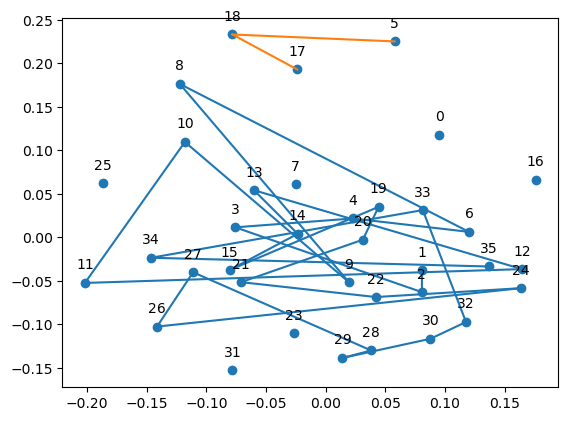

persistence =0.10455799534577592, finding: [12, 16]
 [[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35], [17, 18, 5]]
merging
[[16]]
[[0, 0]]
pbow:
[array([ 6., 10., 11.]), array([0., 0., 2.])]
[[ 0.         14.73091986]
 [14.73091986  0.        ]]
score x0.5166666666666667: [0.17857142857142858] [0.0] 
total score : 0.8611111111111112

[[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35], [17, 18, 5]]


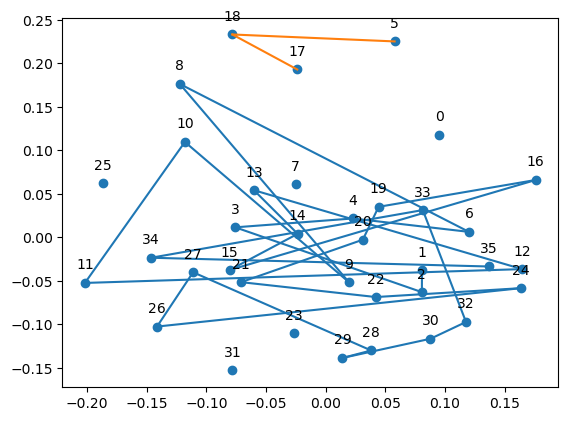

persistence =0.10920565634791612, finding: [23, 28]
 [[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35], [17, 18, 5]]
merging
[[23]]
[[0, 0]]
pbow:
[array([ 6., 11., 11.]), array([0., 0., 2.])]
[[ 0.         15.42724862]
 [15.42724862  0.        ]]
score x0.5333333333333333: [0.1724137931034483] [0.0] 
total score : 0.8611111111111112

[[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35], [17, 18, 5]]


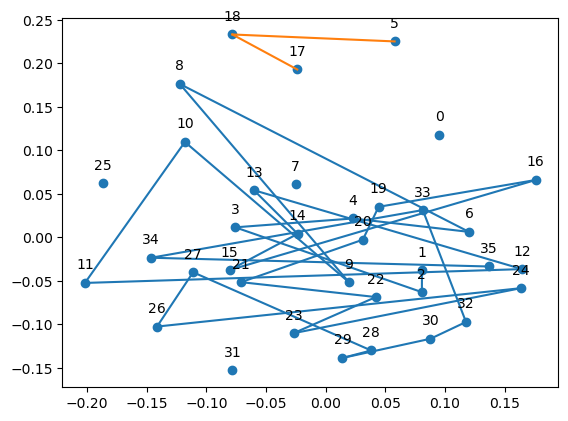

persistence =0.11466409696216495, finding: [29, 31]
 [[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]
merging
[[31]]
[[0, 0]]
pbow:
[array([12.,  6., 11.]), array([0., 0., 2.])]
[[ 0.         16.15549442]
 [16.15549442  0.        ]]
score x0.55: [0.2] [0.0] 
total score : 0.8333333333333334

[[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]


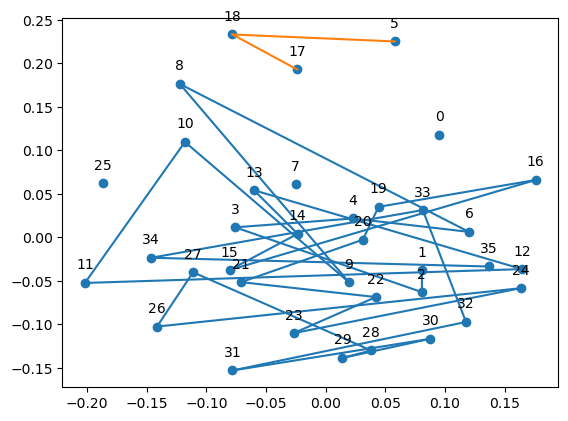

persistence =0.12062947269705138, finding: [7, 28]
 [[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]
merging
[[7]]
[[0, 0]]
pbow:
[array([11., 13.,  6.]), array([2., 0., 0.])]
[[ 0.         16.91153453]
 [16.91153453  0.        ]]
score x0.5666666666666667: [0.1935483870967742] [0.0] 
total score : 0.8333333333333334

[[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]


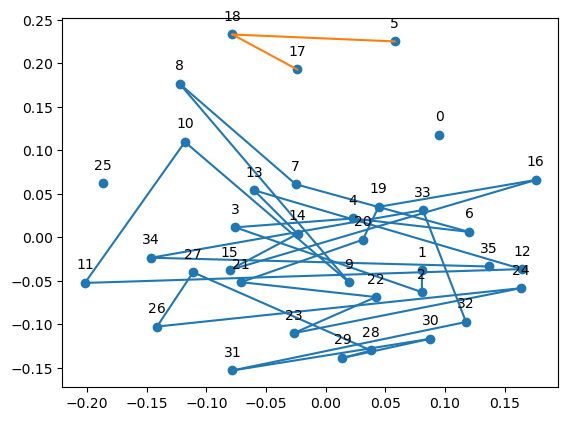

persistence =0.1297202655680899, finding: [0, 6]
 [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]
merging
[[0]]
[[0, 0]]
pbow:
[array([14.,  6., 11.]), array([0., 0., 2.])]
[[ 0.         17.69180601]
 [17.69180601  0.        ]]
score x0.5833333333333334: [0.1875] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [17, 18, 5]]


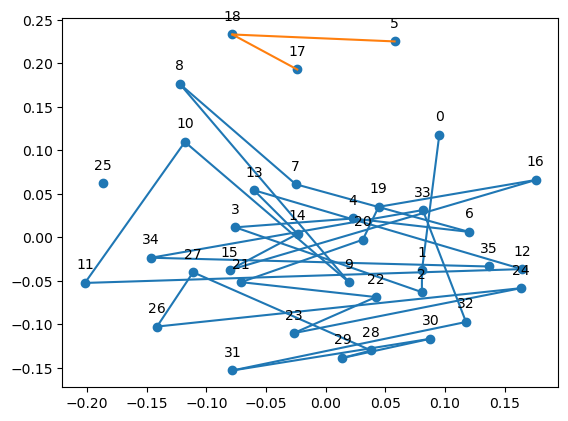

persistence =0.1336462571500514, finding: [7, 17]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[5, 17, 18], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.69180601295413 17.69180601295413
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



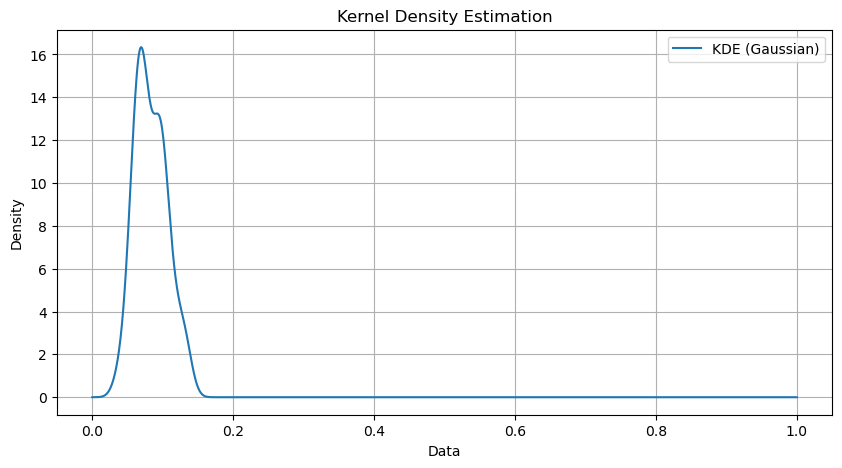

26 (36, 36)


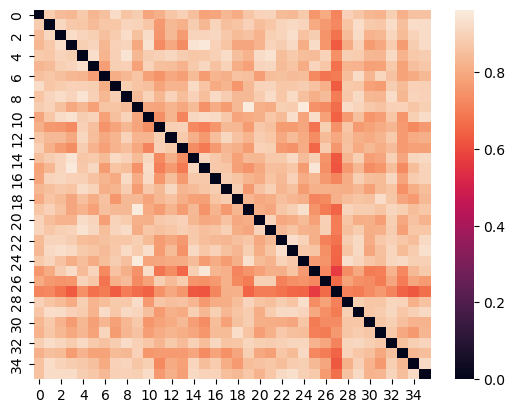

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


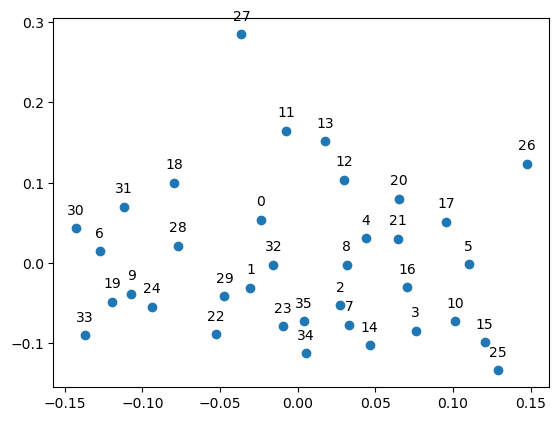

d 0 0 0.0 inf []
d 0 1 0.0 0.18135707461894268 [[18, 27]]
d 0 2 0.0 0.10977339459280555 [[30, 32]]
d 0 3 0.0 0.10402228116920775 [[11, 13]]
d 0 4 0.0 0.10370588858606367 [[13, 20]]
d 0 5 0.0 0.10067122723019473 [[4, 26]]
d 0 6 0.0 0.09320025059501824 [[6, 31]]
d 0 7 0.0 0.09009842961904346 [[28, 32]]
d 0 8 0.0 0.08684946211532685 [[4, 12]]
d 0 9 0.0 0.08542840480725977 [[24, 33]]
d 0 10 0.0 0.08190011668794717 [[7, 14]]
d 0 11 0.0 0.07947087066420833 [[10, 16]]
d 0 12 0.0 0.07788559248873295 [[4, 20]]
d 0 13 0.0 0.07633702805197973 [[4, 17]]
d 0 14 0.0 0.07630299893906223 [[2, 29]]
d 0 15 0.0 0.07608585516685051 [[0, 7]]
d 0 16 0.0 0.0760451762202905 [[6, 29]]
d 0 17 0.0 0.07351306642050093 [[1, 34]]
d 0 18 0.0 0.07280762042875821 [[2, 8]]
d 0 19 0.0 0.07196992509015543 [[1, 29]]
d 0 20 0.0 0.07173784534525374 [[18, 31]]
d 0 21 0.0 0.071677608374485 [[1, 32]]
d 0 22 0.0 0.07044355301375171 [[24, 28]]
d 0 23 0.0 0.06993746615880414 [[22, 23]]
d 0 24 0.0 0.06991902904394953 [[10, 23]]
d 

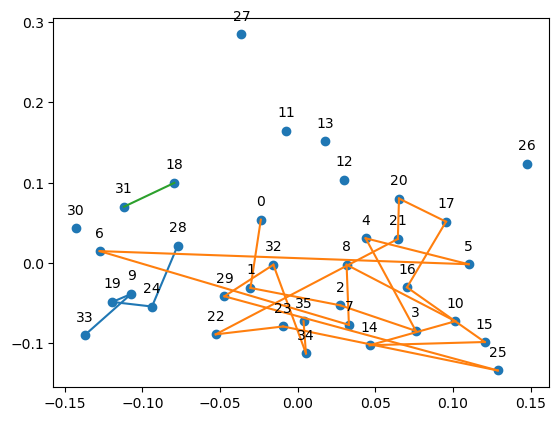

persistence =0.09009842961904346, finding: [4, 12]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 20, 21, 22, 23, 25, 29, 32, 34, 35], [33, 9, 19, 24, 28], [18, 31]]
merging
[[12]]
[[1, 0]]
pbow:
[array([ 6., 17.]), array([2., 2.]), array([0., 1.])]
[[ 0.         15.5241747  17.08800749]
 [15.5241747   0.          2.23606798]
 [17.08800749  2.23606798  0.        ]]
score x0.5166666666666667: [0.125] [0.2] [0.5] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 20, 21, 22, 23, 25, 29, 32, 34, 35], [33, 9, 19, 24, 28], [18, 31]]


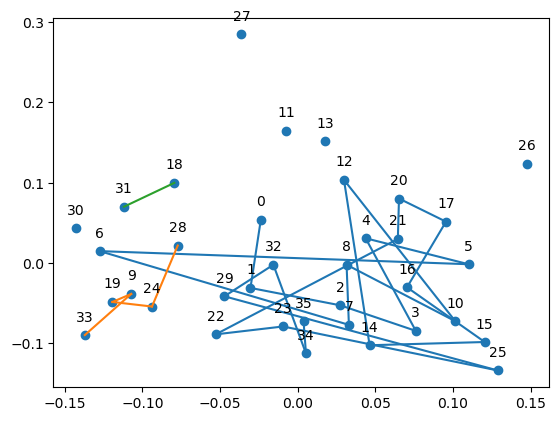

persistence =0.09320025059501824, finding: [28, 32]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35], [18, 31]]
merging
[[9, 19, 24, 28, 33], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 20, 21, 22, 23, 25, 29, 32, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.524174696260024 17.08800749063506
pbow:
[array([20.,  8.]), array([1., 0.])]
[[ 0.         20.61552813]
 [20.61552813  0.        ]]
score x0.5166666666666667: [0.13793103448275862] [0.5] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35], [18, 31]]


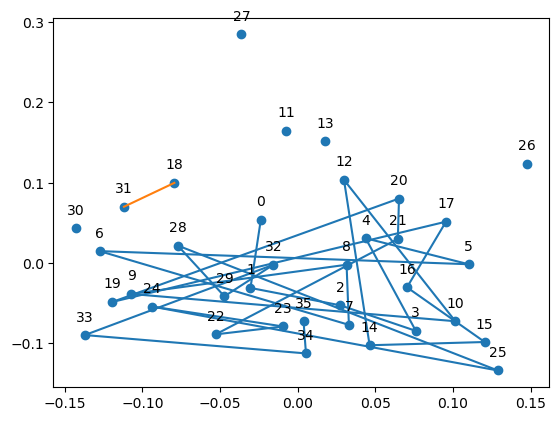

persistence =0.10067122723019473, finding: [6, 31]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 31, 32, 33, 34, 35]]
merging
[[18, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  20.615528128088304 20.615528128088304
score x0.5166666666666667: [0.16129032258064516] 
total score : 0.8611111111111112

persistence =0.10370588858606367, finding: [4, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35]]
merging
[[26]]
[[0, 0]]
score x0.5333333333333333: [0.15625] 
total score : 0.8611111111111112

persistence =0.10402228116920775, finding: [13, 20]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35]]
merging
[[13]]
[[0, 0]]
score x0.55: [0.15151515151515152] 
total score : 0.8611111111111

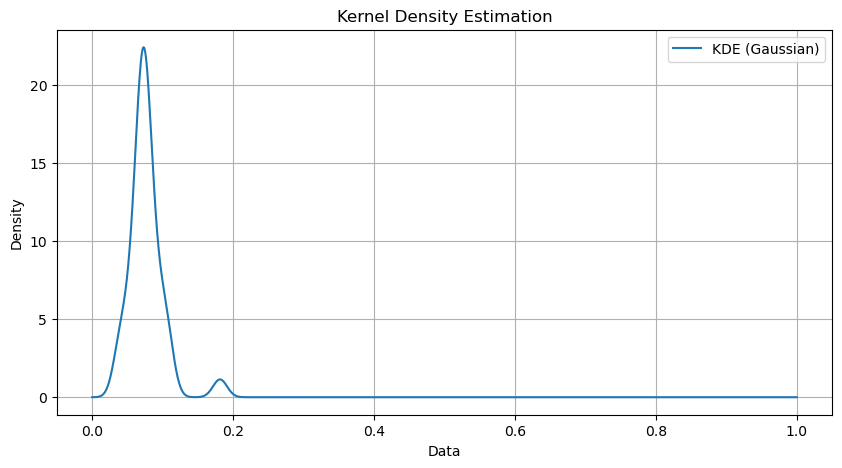

24 (36, 36)


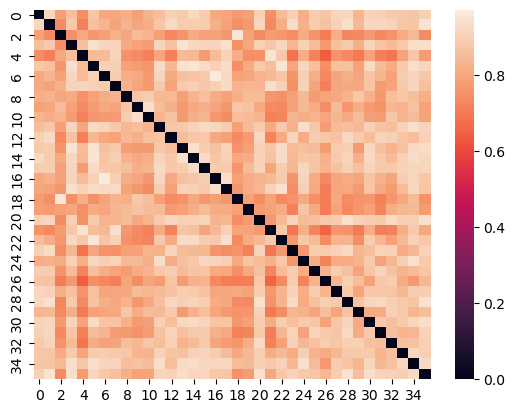

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


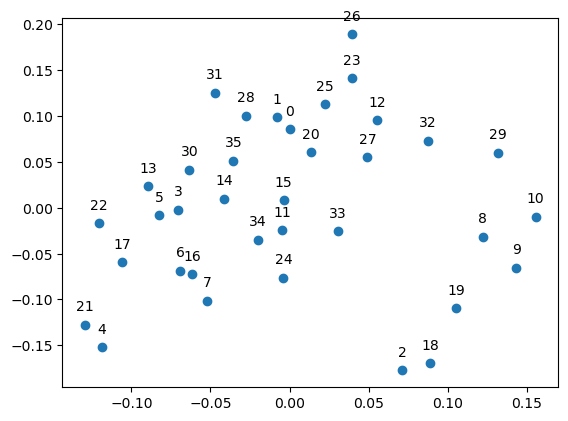

d 0 0 0.0 inf []
d 0 1 0.0 0.13128415990565734 [[19, 24]]
d 0 2 0.0 0.12207934142488786 [[8, 33]]
d 0 3 0.0 0.12134827032521922 [[9, 18]]
d 0 4 0.0 0.10537777122488157 [[8, 10]]
d 0 5 0.0 0.10165068719032311 [[26, 28]]
d 0 6 0.0 0.09696647797759239 [[20, 29]]
d 0 7 0.0 0.08707992450438862 [[25, 31]]
d 0 8 0.0 0.08555003871758793 [[0, 27]]
d 0 9 0.0 0.08509402033100189 [[33, 34]]
d 0 10 0.0 0.07786524635375647 [[28, 31]]
d 0 11 0.0 0.07615160809293053 [[0, 14]]
d 0 12 0.0 0.07607424646388972 [[1, 12]]
d 0 13 0.0 0.07235169308896594 [[20, 32]]
d 0 14 0.0 0.07211564848918861 [[7, 17]]
d 0 15 0.0 0.07183369776837378 [[5, 15]]
d 0 16 0.0 0.06893810578649617 [[1, 23]]
d 0 17 0.0 0.0663610793617816 [[16, 17]]
d 0 18 0.0 0.06265730782000123 [[3, 35]]
d 0 19 0.0 0.062015516415378946 [[7, 21]]
d 0 20 0.0 0.060374514509460964 [[9, 10]]
d 0 21 0.0 0.06030790609915748 [[3, 34]]
d 0 22 0.0 0.059716166566795126 [[30, 35]]
d 0 23 0.0 0.05957147652483741 [[11, 34]]
d 0 24 0.0 0.05875631208376075 [[24, 

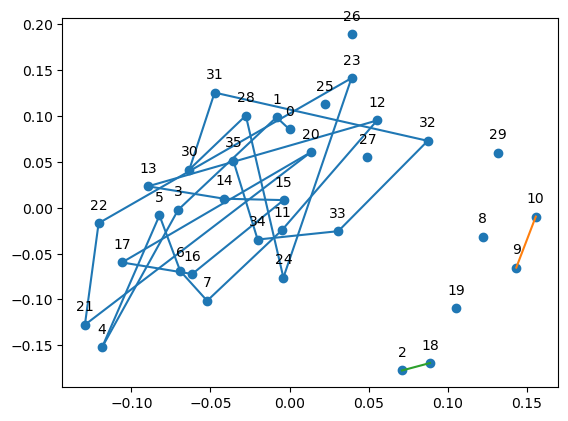

persistence =0.08707992450438862, finding: [0, 27]
 [[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]
merging
[[27]]
[[0, 0]]
pbow:
[array([16., 10.]), array([1., 0.]), array([1., 0.])]
[[ 0.         18.02775638 18.02775638]
 [18.02775638  0.          0.        ]
 [18.02775638  0.          0.        ]]
score x0.5166666666666667: [0.2222222222222222] [0.0] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]


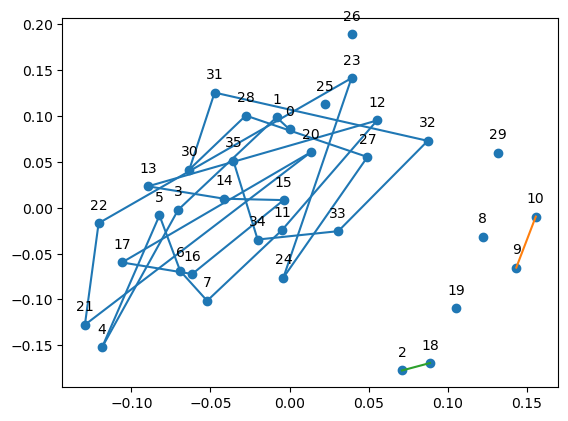

persistence =0.09696647797759239, finding: [25, 31]
 [[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]
merging
[[25]]
[[0, 0]]
pbow:
[array([11., 16.]), array([0., 1.]), array([0., 1.])]
[[ 0.         18.60107524 18.60107524]
 [18.60107524  0.          0.        ]
 [18.60107524  0.          0.        ]]
score x0.5333333333333333: [0.21428571428571427] [0.0] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]


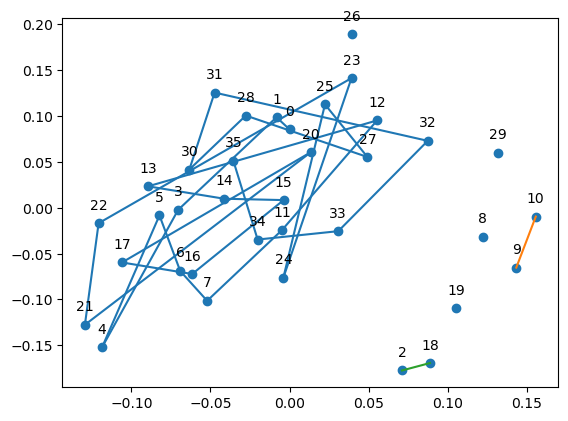

persistence =0.10165068719032311, finding: [20, 29]
 [[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]
merging
[[29]]
[[0, 0]]
pbow:
[array([12., 16.]), array([0., 1.]), array([0., 1.])]
[[ 0.         19.20937271 19.20937271]
 [19.20937271  0.          0.        ]
 [19.20937271  0.          0.        ]]
score x0.55: [0.20689655172413793] [0.0] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]


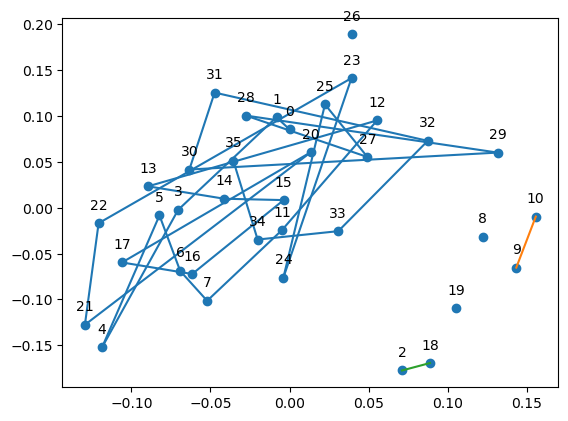

persistence =0.10537777122488157, finding: [26, 28]
 [[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]
merging
[[26]]
[[0, 0]]
pbow:
[array([17., 12.]), array([1., 0.]), array([1., 0.])]
[[ 0. 20. 20.]
 [20.  0.  0.]
 [20.  0.  0.]]
score x0.5666666666666667: [0.2] [0.0] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 10], [2, 18]]


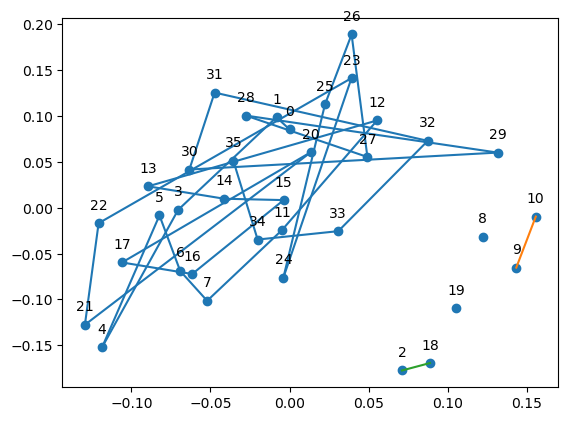

persistence =0.12134827032521922, finding: [8, 10]
 [[8, 9, 10], [0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]
merging
[[8]]
[[1, 0]]
pbow:
[array([1., 1.]), array([17., 12.]), array([1., 0.])]
[[ 0.         19.41648784  1.        ]
 [19.41648784  0.         20.        ]
 [ 1.         20.          0.        ]]
score x0.5833333333333334: [0.0] [0.2] [0.0] 
total score : 0.8333333333333334

[[8, 9, 10], [0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]


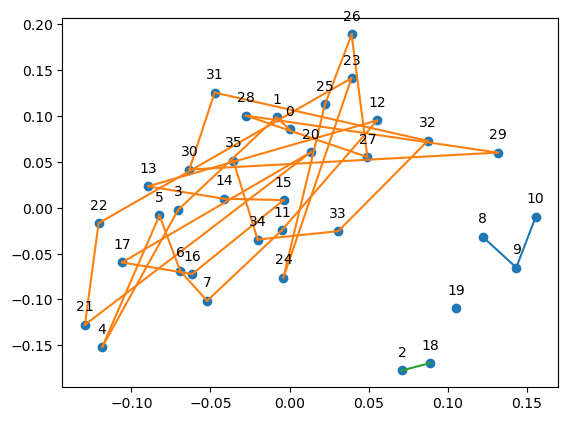

persistence =0.12207934142488786, finding: [9, 18]
 [[2, 8, 9, 10, 18], [0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[2, 18], [8, 9, 10]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  1.0 20.0
pbow:
[array([0., 0., 1., 2., 1.]), array([ 1.,  9., 10.,  2.,  7.])]
[[ 0.         14.10673598]
 [14.10673598  0.        ]]
score x0.5833333333333334: [0.0] [0.2] 
total score : 0.8333333333333334

[[2, 8, 9, 10, 18], [0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]


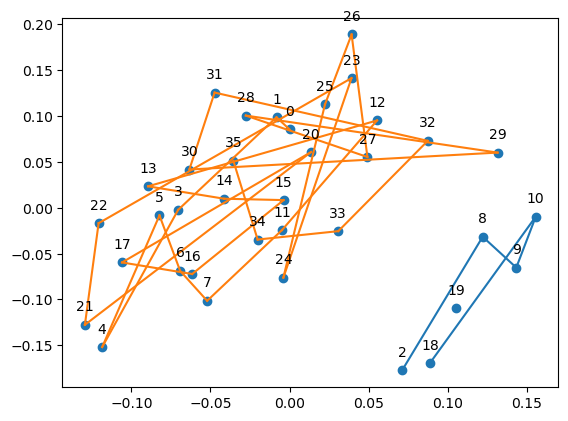

persistence =0.13128415990565734, finding: [8, 33]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 8, 9, 10, 18]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.106735979665885 14.106735979665885
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



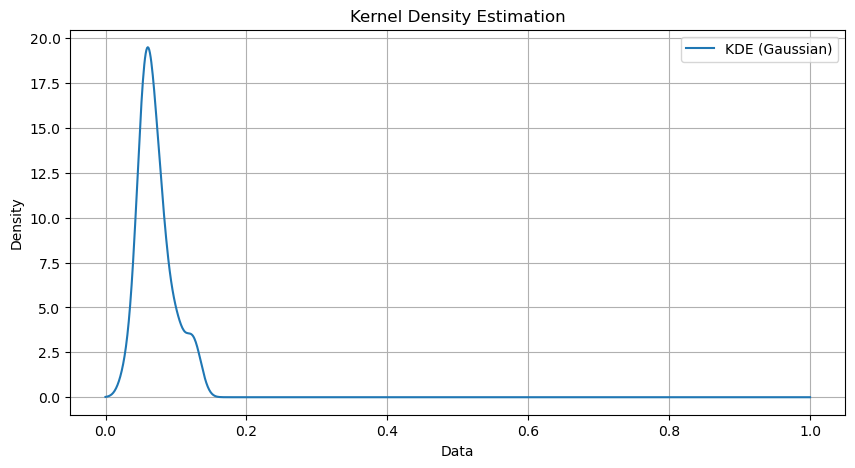

22 (36, 36)


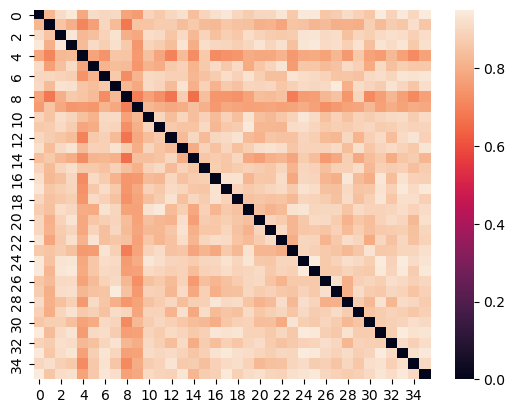

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


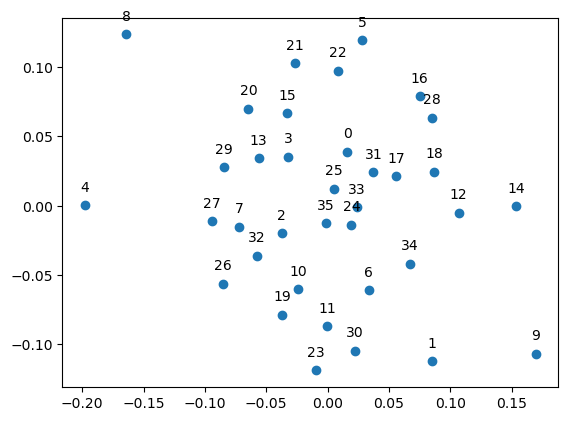

d 0 0 0.0 inf []
d 0 1 0.0 0.14692012560640955 [[1, 9]]
d 0 2 0.0 0.13146272387789515 [[4, 29]]
d 0 3 0.0 0.10377336050924091 [[8, 29]]
d 0 4 0.0 0.09860808893152284 [[14, 18]]
d 0 5 0.0 0.08208288391519947 [[1, 34]]
d 0 6 0.0 0.08145301136296346 [[3, 15]]
d 0 7 0.0 0.07754892047199857 [[26, 27]]
d 0 8 0.0 0.0746228561817398 [[13, 21]]
d 0 9 0.0 0.07445452372236039 [[7, 32]]
d 0 10 0.0 0.07387507716496977 [[3, 29]]
d 0 11 0.0 0.07370637294988713 [[12, 18]]
d 0 12 0.0 0.0720583974337764 [[2, 7]]
d 0 13 0.0 0.07103893137522566 [[5, 22]]
d 0 14 0.0 0.06994156873400104 [[3, 20], [23, 30]]
d 0 15 0.0 0.06994061235194216 [[3, 20], [23, 30]]
d 0 16 0.0 0.0695046390807681 [[6, 23]]
d 0 17 0.0 0.06831993923021396 [[12, 34]]
d 0 18 0.0 0.06801109985058318 [[18, 31]]
d 0 19 0.0 0.06789081783701845 [[19, 24]]
d 0 20 0.0 0.06575753503969117 [[0, 22]]
d 0 21 0.0 0.0657377655765643 [[13, 35]]
d 0 22 0.0 0.06438885788560078 [[16, 28]]
d 0 23 0.0 0.06413178262144259 [[10, 24]]
d 0 24 0.0 0.063490243308

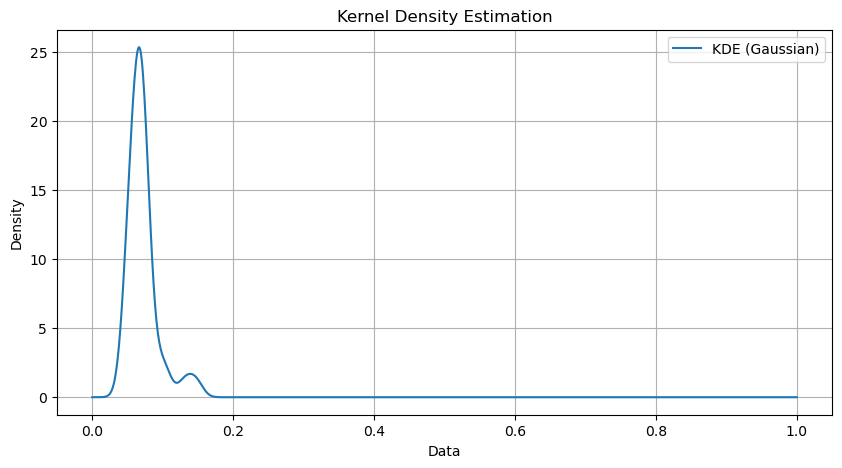

In [8]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    dv_seq = grouping(data, total_nums, normal_nums, mds_results)

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
